In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (15, 10)

import seaborn as sns
from scipy import stats
!pip install statsmodels
import statsmodels.api as sm
import time

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
app_train = pd.read_csv("app_train_red.csv", index_col = 0)
app_test = pd.read_csv("app_test_red.csv")
prev_app = pd.read_csv("previous_application.csv")

In [3]:
prev_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
prev_app.NAME_CONTRACT_STATUS.value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

In [5]:
# Were current customers approved for a previous loan?
print(app_train.SK_ID_CURR.isin(prev_app.SK_ID_CURR).value_counts())
print(app_test.SK_ID_CURR.isin(prev_app.SK_ID_CURR).value_counts())

True     291057
False     16454
Name: SK_ID_CURR, dtype: int64
True     47800
False      944
Name: SK_ID_CURR, dtype: int64


Not everyone has previously applied for a credit line from Home Credit thus there are quite a few new borrowers, 16454 in fact. Makes sense given the areas Home Credit usually services, meaning since they primarily service Asian countries which tend to be largely cash based blah blah something about them not really using banks and there being the potential for a lot of new customers for lenders (emerging new markets).

In [6]:
# How many have the current customers applied for loans before? What is their approval rate?
approval_rate = prev_app.groupby("SK_ID_CURR").NAME_CONTRACT_STATUS.agg(total_apps = "count").reset_index()
approval_rate.total_apps

0         1
1         1
2         3
3         1
4         2
         ..
338852    1
338853    1
338854    2
338855    2
338856    8
Name: total_apps, Length: 338857, dtype: int64

In [7]:
approval_rate = pd.pivot_table(prev_app, index = ["SK_ID_CURR"], columns = ["NAME_CONTRACT_STATUS"], values = "AMT_ANNUITY", aggfunc = len, fill_value=0)

In [ ]:
rates = approval_rate.apply(lambda x: x/sum(x), axis = 1)
rates.columns = rates.columns + "_rate"

In [ ]:
approval_rate["total_apps"] = approval_rate.sum(axis = 1)
approval_rate
approval_rate = approval_rate.join(rates)

In [ ]:
approval_rate = approval_rate.reset_index()
approval_rate.head()

NAME_CONTRACT_STATUS,SK_ID_CURR,Approved,Canceled,Refused,Unused offer,total_apps,Approved_rate,Canceled_rate,Refused_rate,Unused offer_rate
0,100001,1,0,0,0,1,1.0,0.0,0.0,0.0
1,100002,1,0,0,0,1,1.0,0.0,0.0,0.0
2,100003,3,0,0,0,3,1.0,0.0,0.0,0.0
3,100004,1,0,0,0,1,1.0,0.0,0.0,0.0
4,100005,1,1,0,0,2,0.5,0.5,0.0,0.0


In [ ]:
# Does the current customer have a previous loan with Home Credit (ie do they have data in the previous application dataset)
has_prev_app =  pd.DataFrame(app_train.SK_ID_CURR.isin(prev_app.SK_ID_CURR))
has_prev_app.columns = [ "previously_applied"]
app_train['previously_applied'] = has_prev_app

# Converts boolean columns into columns with 0s and 1s
# pd.DataFrame(app_train.SK_ID_CURR.isin(prev_app.SK_ID_CURR)).astype(int)  

In [ ]:
app_train = app_train.join(approval_rate[["SK_ID_CURR", "total_apps", "Approved_rate"]].set_index("SK_ID_CURR"), on = "SK_ID_CURR")
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,previously_applied,total_apps,Approved_rate
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,True,1.0,1.000000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,True,3.0,1.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,True,1.0,1.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,True,9.0,0.555556
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,True,6.0,1.000000


In [ ]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,previously_applied,total_apps,Approved_rate
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,True,1.0,1.000000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,True,3.0,1.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,True,1.0,1.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,True,9.0,0.555556
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,True,6.0,1.000000


In [ ]:
prev_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='NAME_CLIENT_TYPE', ylabel='count'>

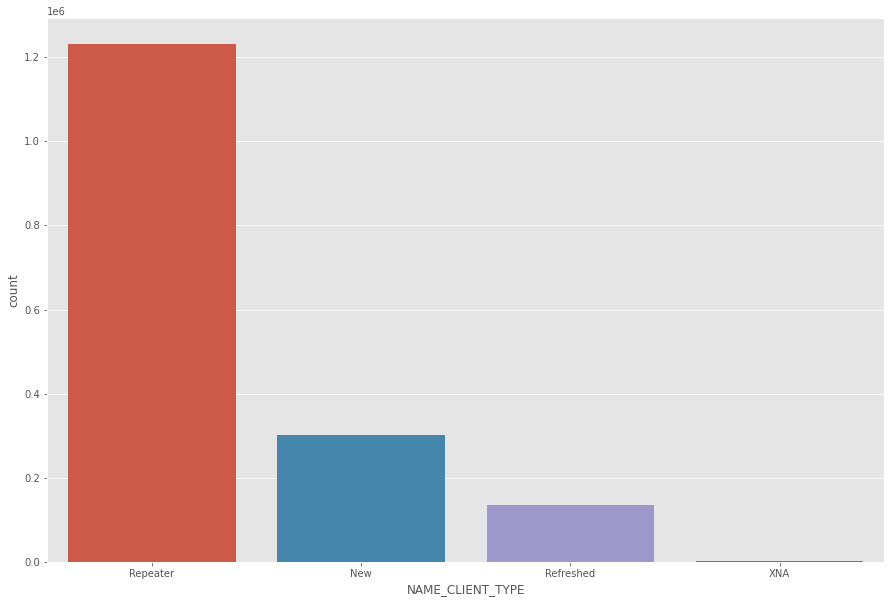

In [ ]:
sns.countplot(prev_app.NAME_CLIENT_TYPE)

In [ ]:
client_type = pd.DataFrame(prev_app.NAME_CLIENT_TYPE == "New")
client_type.columns = ["repeat_client"]
client_type.repeat_client = client_type.repeat_client == False
client_type["SK_ID_CURR"] = prev_app.SK_ID_CURR

In [ ]:
prev_app.groupby(["SK_ID_CURR", "NAME_CLIENT_TYPE"]).NAME_CLIENT_TYPE.agg(count="count").reset_index()

,SK_ID_CURR,NAME_CLIENT_TYPE,count
0,100001,Refreshed,1
1,100002,New,1
2,100003,Refreshed,2
3,100003,Repeater,1
4,100004,New,1
...,...,...,...
623120,456253,Repeater,1
623121,456254,New,1
623122,456254,Repeater,1
623123,456255,Refreshed,1


<AxesSubplot:xlabel='NAME_CLIENT_TYPE', ylabel='Approved_rate'>

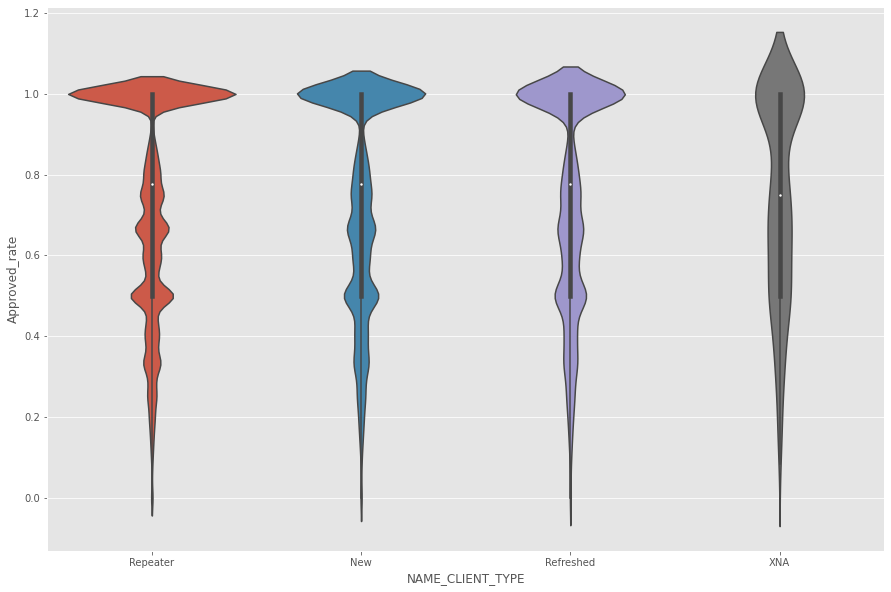

In [ ]:
sns.violinplot(x = prev_app.NAME_CLIENT_TYPE, y = approval_rate.Approved_rate)

In [ ]:
prev_app.sort_values("SK_ID_CURR").head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
201668,1369693,100001,Consumer loans,3951.000,24835.5,23787.0,2520.0,24835.5,FRIDAY,13,...,Connectivity,8.0,high,POS mobile with interest,365243.0,-1709.0,-1499.0,-1619.0,-1612.0,0.0
892077,1038818,100002,Consumer loans,9251.775,179055.0,179055.0,0.0,179055.0,SATURDAY,9,...,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
575941,1810518,100003,Cash loans,98356.995,900000.0,1035882.0,NaN,900000.0,FRIDAY,12,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0
1021650,2636178,100003,Consumer loans,64567.665,337500.0,348637.5,0.0,337500.0,SUNDAY,17,...,Furniture,6.0,middle,POS industry with interest,365243.0,-797.0,-647.0,-647.0,-639.0,0.0
1223745,2396755,100003,Consumer loans,6737.310,68809.5,68053.5,6885.0,68809.5,SATURDAY,15,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-2310.0,-1980.0,-1980.0,-1976.0,1.0


In [ ]:
sns.

[[ 1.         -0.54895953]
 [-0.54895953  1.        ]]


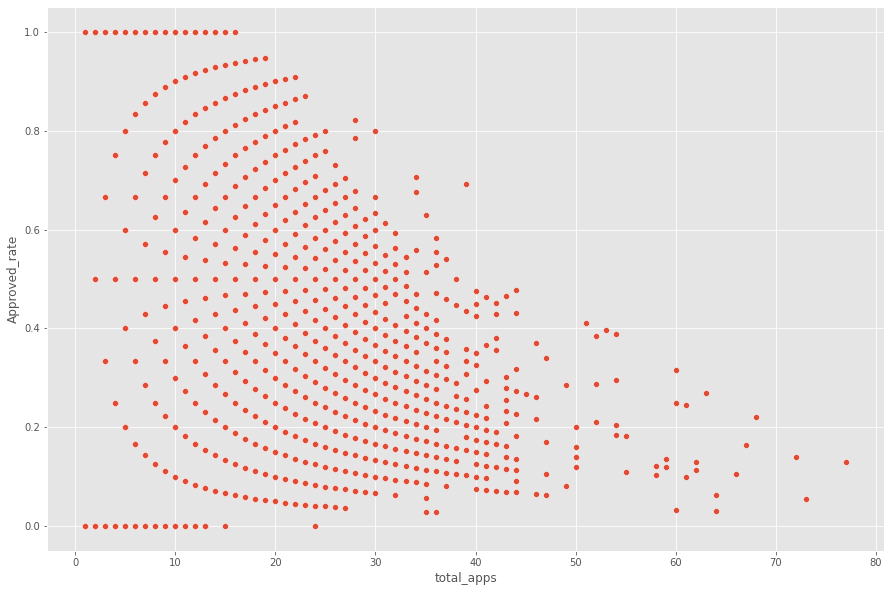

In [ ]:
# Weird patters. There seem to be circular patters, perhaps corresponding to groups when comparing the total number of applications a 
    # client submitted vs the approval rate of their applications. As expected, generally, the more applications are submitted, the lower the approval rate
sns.scatterplot(x =  approval_rate.total_apps, y = approval_rate.Approved_rate)
print(np.corrcoef( approval_rate.total_apps, approval_rate.Approved_rate))

[[ 1.         -0.54895953]
 [-0.54895953  1.        ]]


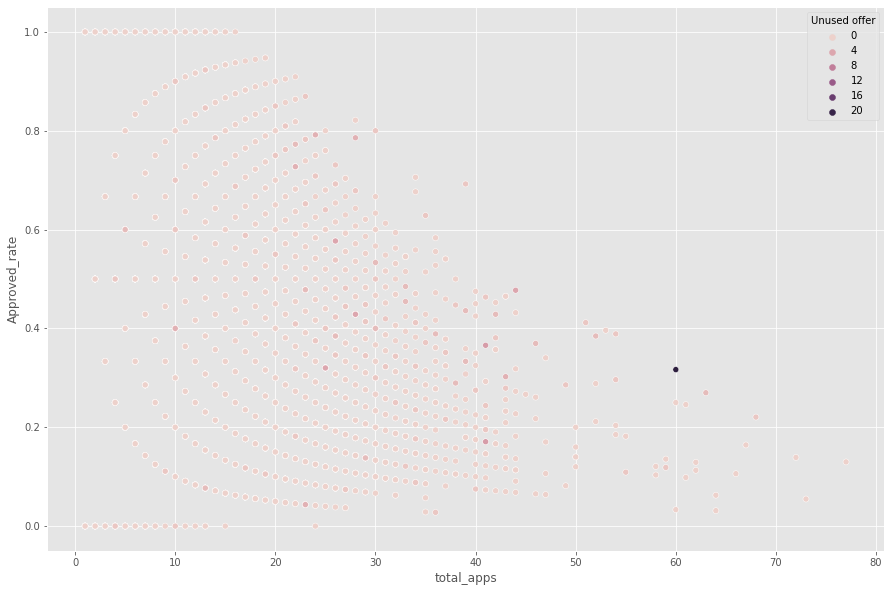

In [ ]:
# There is an odd duck that submitted a lot of applications of which a large percentage were approved, but also had a lot of unused offers
sns.scatterplot(x =  approval_rate.total_apps, y = approval_rate.Approved_rate, hue = approval_rate["Unused offer"])

array([[ 1.        , -0.60713159],
       [-0.60713159,  1.        ]])

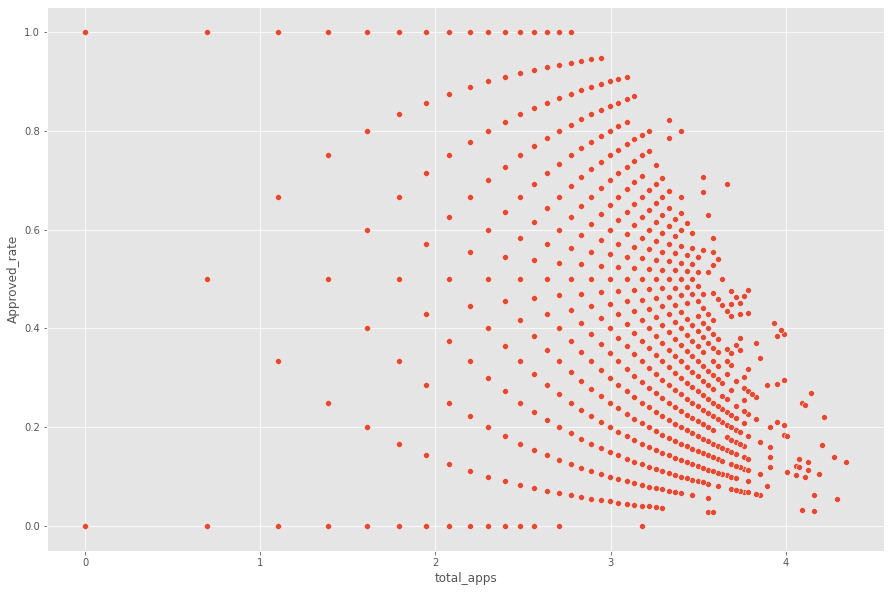

In [ ]:
condition =  approval_rate["Unused offer"] < 20
sns.scatterplot(x =  np.log(approval_rate.total_apps[condition]), y = approval_rate.Approved_rate[condition] )
np.corrcoef(np.log(approval_rate.total_apps[condition]), approval_rate.Approved_rate[condition] )

In [ ]:
np.corrcoef(approval_rate.total_apps, np.log(approval_rate.Approved_rate))

array([[ 1.        , -0.54895953],
       [-0.54895953,  1.        ]])

In [ ]:
np.log(approval_rate.Approved_rate)

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0         0.000000
1         0.000000
2         0.000000
3         0.000000
4        -0.693147
            ...   
338852    0.000000
338853    0.000000
338854    0.000000
338855    0.000000
338856   -0.287682
Name: Approved_rate, Length: 338857, dtype: float64

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9263f292-ea73-48e7-8892-f3d3ed1db03c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>